# Imports

In [39]:
import pandas  as pd
import seaborn as sns
import joblib
import numpy  as np

import matplotlib.pyplot as plt
import plotly.express    as px
import seaborn           as sns

from sklearn.model_selection import train_test_split
from category_encoders       import OneHotEncoder,TargetEncoder,BinaryEncoder
from sklearn.model_selection import TimeSeriesSplit

# models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,roc_auc_score,confusion_matrix
from sklearn.model_selection import cross_val_predict, StratifiedKFold


### 0.0 - Functions

In [2]:
def encoding_trainig_data( df, y):

    dict_encoders = {}
    
    df_cat = df.select_dtypes(include=['object']).columns
    
    unique_count = df[df_cat].nunique() 
    
    df_aux = pd.DataFrame(unique_count).reset_index().rename(columns = {'index': 'category', 0: 'count'})

    for line in df_aux.iterrows():

        # applying one hot encoding
        if line[1]['count'] >=2 and line[1]['count'] <=6:

            ohe = OneHotEncoder(handle_unknown='value')

            ohe_trained = ohe.fit( df[ [ line[1]['category'] ] ])

            joblib.dump(ohe_trained, f'encoders/ohe_trained{line[1]['category']}.pkl')

            df_ohe = ohe_trained.transform( df[ [ line[1]['category'] ] ] ) 

            df = pd.concat( [df, df_ohe] , axis = 1 ).drop( line[1]['category'], axis = 1 )
            
            print(f'One Hot Encoding columns applied to: {line[1]['category']} column that has {line[1]['count']} values.')

            dict_encoders[line[1]['category']] = 'OneHotEncoder'

        # applying target encoding
        if line[1]['count'] >=10 and line[1]['count'] <=60:

            te = TargetEncoder(handle_unknown='value')

            te_trained = te.fit( df[ [ line[1]['category'] ] ] , y = y )

            joblib.dump(te_trained, f'encoders/te_trained{line[1]['category']}.pkl')

            df[ line[1]['category'] ] = te_trained.transform( df[ [ line[1]['category'] ] ] ) 

            print( f'Target Enconding applied to: {line[1]['category']} column that has {line[1]['count']} values.' )

            dict_encoders[line[1]['category']] = 'TargetEncoder'

        # applying frequency encoding
        if line[1]['count'] >=60:

            category_counts = df[ line[1]['category'] ].value_counts()

            df[ line[1]['category'] ] =  df[ line[1]['category'] ].map( category_counts )

            joblib.dump(category_counts, f'encoders/category_counts{line[1]['category']}.pkl')

            print(f'Frequency Encoding applied to: {line[1]['category']} column that has {line[1]['count']} values.')

            dict_encoders[line[1]['category']] = 'category_counts'
            
    return df, dict_encoders


def transform_data(df):

    df['trans_date_trans_time'] = pd.to_datetime( df['trans_date_trans_time']  )

    df['dob'] = pd.to_datetime( df['dob'] )

    # extract year
    df['trans_date_trans_time_year'] = df['trans_date_trans_time'].dt.year

    # extract month
    df['trans_date_trans_time_month'] = df['trans_date_trans_time'].dt.month

    # extract day
    df['trans_date_trans_time_day'] = df['trans_date_trans_time'].dt.day

    # convert into datetime format
    df['dob'] = pd.to_datetime(df['dob'])

    # extract year from dob
    df['dob_year'] = df['dob'].dt.year
    
    # extract month from dob
    df['dob_month'] = df['dob'].dt.month

    # extract day from dob
    df['dob_day'] = df['dob'].dt.day

    df = df.drop( ['dob','trans_date_trans_time','Unnamed: 0','trans_num'], axis = 1 )

    

    return df

def encoding_trainig_data( df, y):

    dict_encoders = {}
    
    df_cat = df.select_dtypes(include=['object']).columns
    
    unique_count = df[df_cat].nunique() 
    
    df_aux = pd.DataFrame(unique_count).reset_index().rename(columns = {'index': 'category', 0: 'count'})

    for line in df_aux.iterrows():

        # applying one hot encoding
        if line[1]['count'] >=2 and line[1]['count'] <=6:

            ohe = OneHotEncoder(handle_unknown='value')

            ohe_trained = ohe.fit( df[ [ line[1]['category'] ] ])

            joblib.dump(ohe_trained, f'encoders/ohe_trained{line[1]['category']}.pkl')

            df_ohe = ohe_trained.transform( df[ [ line[1]['category'] ] ] ) 

            df = pd.concat( [df, df_ohe] , axis = 1 ).drop( line[1]['category'], axis = 1 )
            
            print(f'One Hot Encoding columns applied to: {line[1]['category']} column that has {line[1]['count']} values.')

            dict_encoders[line[1]['category']] = 'OneHotEncoder'

        # applying target encoding
        if line[1]['count'] >=10 and line[1]['count'] <=60:

            te = TargetEncoder(handle_unknown='value')

            te_trained = te.fit( df[ [ line[1]['category'] ] ] , y = y )

            joblib.dump(te_trained, f'encoders/te_trained{line[1]['category']}.pkl')

            df[ line[1]['category'] ] = te_trained.transform( df[ [ line[1]['category'] ] ] ) 

            print( f'Target Enconding applied to: {line[1]['category']} column that has {line[1]['count']} values.' )

            dict_encoders[line[1]['category']] = 'TargetEncoder'

        # applying frequency encoding
        if line[1]['count'] >=60:

            category_counts = df[ line[1]['category'] ].value_counts()

            df[ line[1]['category'] ] =  df[ line[1]['category'] ].map( category_counts )

            joblib.dump(category_counts, f'encoders/category_counts{line[1]['category']}.pkl')

            print(f'Frequency Encoding applied to: {line[1]['category']} column that has {line[1]['count']} values.')

            dict_encoders[line[1]['category']] = 'category_counts'
            
    return df, dict_encoders
    
def encoding_test_data(df, enconding_map ):

    test_cat_columns = df.select_dtypes( include = 'object' ).columns

    for chave,valor in enconding_map.items():
        
        if valor == 'category_counts':

            print(f'encodar como {valor} a coluna {chave}')
    
            fe_trained = joblib.load( f'encoders/category_counts{chave}.pkl' )
            
            df[chave] = df[chave].map( fe_trained )

        if valor == 'TargetEncoder':

            print(f'encodar como {valor} a coluna {chave}')
    
            te_trained = joblib.load( f'encoders/te_trained{chave}.pkl' )
    
            df[chave] = te_trained.transform( df[chave] )

        if valor == 'OneHotEncoder':

            print(f'encodar como {valor} a coluna {chave}')
    
            ohe = joblib.load( f'encoders/ohe_trained{chave}.pkl' )
    
            df_ohe = ohe.transform( df[chave] )

            df = pd.concat( [df, df_ohe], axis = 1 )

           
    df = df.fillna(0)

    return df.drop( 'gender', axis = 1 )

        
def eveluate_model(model_name, y_test, y_pred, y_pred_proba):

    df_result = pd.DataFrame()

    accuracy = accuracy_score(y_test, y_pred)

    precision = precision_score( y_test , y_pred )

    recall = recall_score( y_test , y_pred )

    f1 = f1_score( y_test , y_pred,average='binary' )

    if y_pred_proba.ndim == 2:
        roc = roc_auc_score(y_test, y_pred_proba[:, 1])  # Usando a probabilidade da classe positiva
    else:
        roc = roc_auc_score(y_test, y_pred_proba)


    dict_results = {'Model Name': model_name,
     'Accuracy_score': accuracy,
     'Precision_score': precision,
     'Recall': recall,
     'F1_score': f1,
     'ROC_AUC' : roc
    }

    return pd.DataFrame( dict_results, index = [0] )
    
        
def evaluate_model_cv(model, X, y, cv=5):


    tscv = TimeSeriesSplit(n_splits=cv)

    
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []
    

    for train_index, val_index in tscv.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    
        model.fit(X_train, y_train)
    
    
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]

    
        accuracy_scores.append(accuracy_score(y_val, y_pred))
        precision_scores.append(precision_score(y_val, y_pred))
        recall_scores.append(recall_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred,average='binary' ))
        if y_pred_proba.ndim == 2:
            roc = roc_auc_score(y_val, y_pred_proba[:, 1])  # Usando a probabilidade da classe positiva
        else:
            roc = roc_auc_score(y_val, y_pred_proba)
    
    
    results = {
        'Model Name': str(model),
        'Accuracy_score': np.mean(accuracy_scores),
        'Precision_score': np.mean(precision_scores),
        'Recall': np.mean(recall_scores),
        'F1_score': np.mean(f1_scores),
        'ROC_AUC': np.mean(roc_auc_scores)
    }
    
    
    return pd.DataFrame(results, index=[0])


## 1.0 Load Data

In [3]:
df = pd.read_csv( r'data/fraudTrain.csv' )
df_test = pd.read_csv(r'data/fraudTest.csv')
df.head().to_csv('sample.data.csv') 

## 2.0 Check Data

In [4]:
df2 = df.copy()

### 2.1 - Check Shape

In [5]:
df2.shape

(1296675, 23)

## 3.0 - Split Data Into Train and Test

In [6]:
df3 = df2.copy()

# convert into datetime format
df3['trans_date_trans_time'] = pd.to_datetime(df3['trans_date_trans_time'])

# order df by customer account and datetime in ascending order 
df3 = df3.sort_values( by = ['cc_num','trans_date_trans_time'], ascending = True )

In [7]:
# min date val
min_date = pd.to_datetime(df_test['trans_date_trans_time']).min() + pd.Timedelta(days=1)

# max date val
max_date_df_test = pd.to_datetime(df_test['trans_date_trans_time']).max()

# max date train val
max_date_val = max_date_df_test - pd.DateOffset(months=3)



In [8]:
# split data into X_train
X_train = df3.drop('is_fraud', axis = 1)

# y_train
y_train = df3['is_fraud']

# X_val
X_val = df_test.loc[ (pd.to_datetime(df_test['trans_date_trans_time']) >= min_date ) & (pd.to_datetime(df_test['trans_date_trans_time']) <= max_date_val), : ]

# y val
y_val = X_val['is_fraud']

# drop y
X_val = X_val.drop('is_fraud', axis = 1)


### Drop Columns

In [9]:
# drop column
X_train = X_train.drop( ['Unnamed: 0','trans_num'], axis = 1 )

### 3.1 - Check Nulls

In [10]:
X_train.isna().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
unix_time                0
merch_lat                0
merch_long               0
dtype: int64

### 3.2 - Check Dtypes

In [11]:
X_train.dtypes

trans_date_trans_time    datetime64[ns]
cc_num                            int64
merchant                         object
category                         object
amt                             float64
first                            object
last                             object
gender                           object
street                           object
city                             object
state                            object
zip                               int64
lat                             float64
long                            float64
city_pop                          int64
job                              object
dob                              object
unix_time                         int64
merch_lat                       float64
merch_long                      float64
dtype: object

### 3.3 - Extract Date Parts

In [12]:
# extract year
X_train['trans_date_trans_time_year'] = X_train['trans_date_trans_time'].dt.year

# extract month
X_train['trans_date_trans_time_month'] = X_train['trans_date_trans_time'].dt.month

# extract day
X_train['trans_date_trans_time_day'] =   X_train['trans_date_trans_time'].dt.day

# convert into datetime format
X_train['dob'] = pd.to_datetime(X_train['dob'])

# extract year from dob
X_train['dob_year'] = X_train['dob'].dt.year

# extract month from dob
X_train['dob_month'] = X_train['dob'].dt.month

# extract day from dob
X_train['dob_day'] = X_train['dob'].dt.day

X_train = X_train.drop( ['dob','trans_date_trans_time'], axis = 1 )


### 3.4 - Pre processing Train Data

In [13]:
X_train, enconding_map = encoding_trainig_data(X_train,y_train)

Frequency Encoding applied to: merchant column that has 693 values.
Target Enconding applied to: category column that has 14 values.
Frequency Encoding applied to: first column that has 352 values.
Frequency Encoding applied to: last column that has 481 values.
One Hot Encoding columns applied to: gender column that has 2 values.
Frequency Encoding applied to: street column that has 983 values.
Frequency Encoding applied to: city column that has 894 values.
Target Enconding applied to: state column that has 51 values.
Frequency Encoding applied to: job column that has 494 values.


### 3.5 - Pre processing Test Data

In [14]:
X_val = transform_data(X_val)

In [15]:
X_val = encoding_test_data( X_val, enconding_map )

encodar como category_counts a coluna merchant
encodar como TargetEncoder a coluna category
encodar como category_counts a coluna first
encodar como category_counts a coluna last
encodar como OneHotEncoder a coluna gender
encodar como category_counts a coluna street
encodar como category_counts a coluna city
encodar como TargetEncoder a coluna state
encodar como category_counts a coluna job


## 4 - Training Models

### Random Forest

In [16]:
# instancing 
rf = RandomForestClassifier( n_estimators=100,
                             class_weight = 'balanced',
                             random_state=42,
                             n_jobs = 8
                           )

rf.fit( X_train, y_train )

y_pred_rf = rf.predict( X_val )

y_prob = rf.predict_proba(X_val)


In [17]:
result_rf = eveluate_model( 'Random Forest', y_val ,y_pred_rf,y_prob )
result_rf

,Model Name,Accuracy_score,Precision_score,Recall,F1_score,ROC_AUC
0,Random Forest,0.996474,0.991701,0.200672,0.333799,0.93074


In [18]:
rf_cv = RandomForestClassifier( n_estimators=100,
                             class_weight = 'balanced',
                             random_state=42,
                             n_jobs = 8
                           )

tscv = 3

result_rf_cv = evaluate_model_cv(rf_cv, X_train ,y_train , tscv )
result_rf_cv

D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Model Name,Accuracy_score,Precision_score,Recall,F1_score,ROC_AUC
0,RandomForestClassifier(class_weight='balanced'...,0.995634,0.982235,0.248162,0.388701,NaN


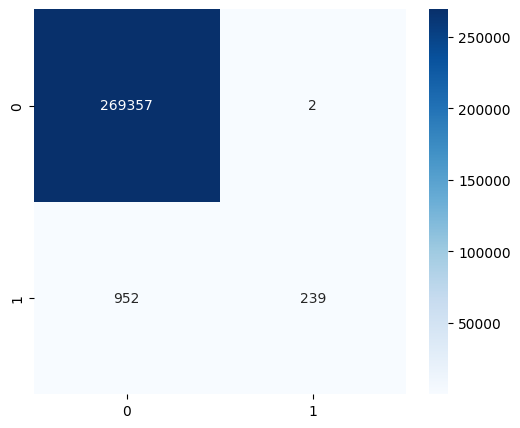

In [19]:
cm = confusion_matrix(y_val, y_pred_rf)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


# Exiba o gráfico
plt.show()

C:\Users\oscar\AppData\Local\Temp\ipykernel_6248\2286433535.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


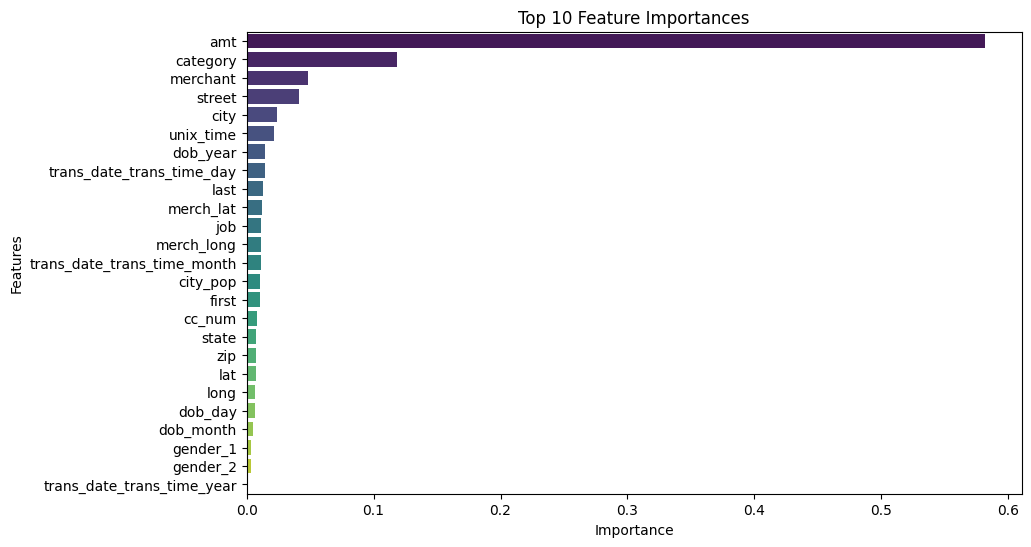

In [20]:
X_train_valimportances = rf.feature_importances_
features = X_train.columns 


df_importances = pd.DataFrame({
    'Feature': features,
    'Importance': X_train_valimportances
})


df_importances = df_importances.sort_values(by='Importance', ascending=False)

top_n = 10
top_features = df_importances


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title(f'Top {top_n} Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

### Xgboost

In [21]:
# instanciating
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=3,  
    objective='binary:logistic', 
    eval_metric='logloss',
    random_state=42
)


xgb_model.fit( X_train, y_train )

y_pred_xgb = xgb_model.predict( X_val )
y_proba = xgb_model.predict_proba( X_val )


In [22]:
result_xgb = eveluate_model( 'xgb', y_val , y_pred_xgb, y_proba )
result_xgb

,Model Name,Accuracy_score,Precision_score,Recall,F1_score,ROC_AUC
0,xgb,0.996888,0.740028,0.451721,0.561001,0.986705


In [23]:
xgb_model_cv = xgb.XGBClassifier(
    scale_pos_weight=3,  
    objective='binary:logistic', 
    eval_metric='logloss', 
    random_state=42
)

tscv_xgb = 3

result_xgb_cv = evaluate_model_cv(xgb_model_cv, X_train ,y_train ,tscv_xgb)
result_xgb_cv

D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Model Name,Accuracy_score,Precision_score,Recall,F1_score,ROC_AUC
0,"XGBClassifier(base_score=None, booster=None, c...",0.996475,0.923317,0.429028,0.576163,NaN


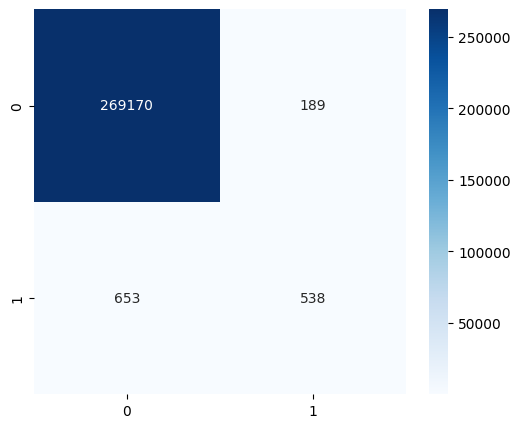

In [24]:
cm = confusion_matrix(y_val, y_pred_xgb)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


# Exiba o gráfico
plt.show()

C:\Users\oscar\AppData\Local\Temp\ipykernel_6248\1167550434.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


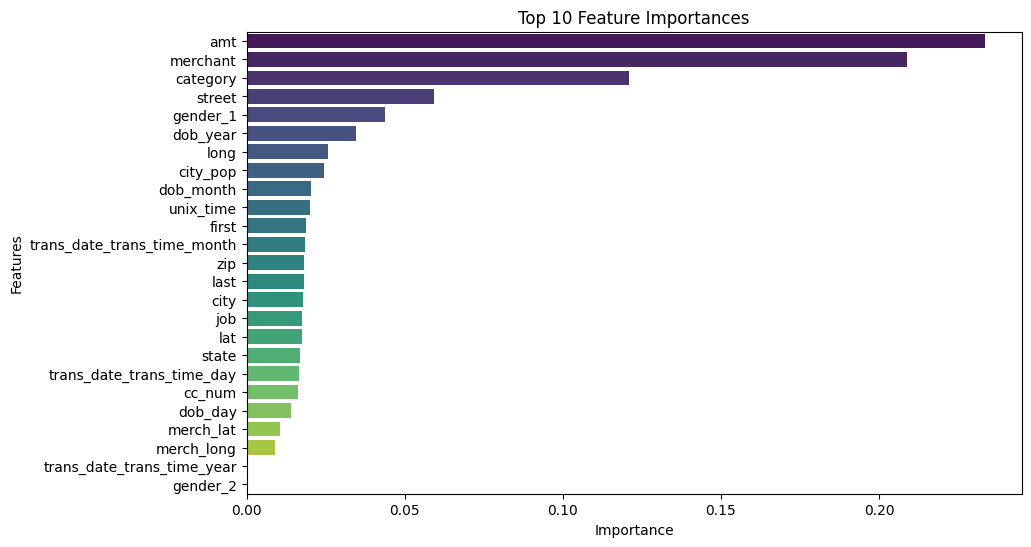

In [25]:
importances = xgb_model.feature_importances_
features = X_train.columns 


df_importances = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})


df_importances = df_importances.sort_values(by='Importance', ascending=False)


top_features = df_importances

top_n = 10
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title(f'Top {top_n} Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

### lgbm

In [26]:
lgb_model = lgb.LGBMClassifier(
    scale_pos_weight=3, 
    objective='binary', 
    random_state=42
)

lgb_model.fit( X_train, y_train )

y_pred_lgbm = lgb_model.predict( X_val )
y_proba = lgb_model.predict_proba( X_val )



[LightGBM] [Info] Number of positive: 7506, number of negative: 1289169
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3965
[LightGBM] [Info] Number of data points in the train set: 1296675, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146050
[LightGBM] [Info] Start training from score -5.146050


In [27]:
result_lgbm = eveluate_model( 'lgb_model', y_val , y_pred_lgbm, y_proba )
result_lgbm

,Model Name,Accuracy_score,Precision_score,Recall,F1_score,ROC_AUC
0,lgb_model,0.991562,0.287217,0.618808,0.392334,0.896992


In [28]:
lgb_model_cv = lgb.LGBMClassifier(
    scale_pos_weight=3, 
    objective='binary', 
    random_state=42
)

tscv_lgbm = 3

result_lgbm_cv = evaluate_model_cv(lgb_model_cv, X_train ,y_train ,tscv_lgbm )
result_lgbm_cv

[LightGBM] [Info] Number of positive: 1873, number of negative: 322298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3637
[LightGBM] [Info] Number of data points in the train set: 324171, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005778 -> initscore=-5.147935
[LightGBM] [Info] Start training from score -5.147935
[LightGBM] [Info] Number of positive: 3649, number of negative: 644690
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3884
[LightGBM] [Info] Number of data points in the train set: 648339, number of used features: 25
[LightGBM] [Info

D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Model Name,Accuracy_score,Precision_score,Recall,F1_score,ROC_AUC
0,"LGBMClassifier(objective='binary', random_stat...",0.984389,0.209781,0.483737,0.290763,NaN


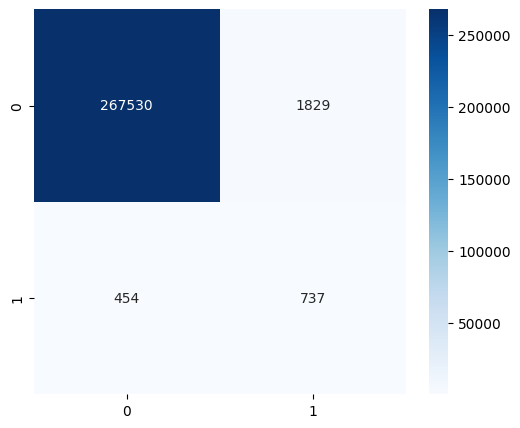

In [29]:
cm = confusion_matrix(y_val, y_pred_lgbm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


# Exiba o gráfico
plt.show()

## Final Result 

In [30]:
pd.concat( [result_rf,result_xgb,result_lgbm],axis = 0 ).sort_values( by = 'F1_score', ascending = False )

,Model Name,Accuracy_score,Precision_score,Recall,F1_score,ROC_AUC
0,xgb,0.996888,0.740028,0.451721,0.561001,0.986705
0,lgb_model,0.991562,0.287217,0.618808,0.392334,0.896992
0,Random Forest,0.996474,0.991701,0.200672,0.333799,0.930740


## 5 - Testing on unseen data

In [31]:
X_test = df_test.loc[ (pd.to_datetime(df_test['trans_date_trans_time']) >= max_date_val ) & (pd.to_datetime(df_test['trans_date_trans_time'])<= max_date_df_test), :]
y_test = X_test['is_fraud']

In [32]:
X_test.shape

(281521, 23)

In [33]:
X_test.is_fraud.value_counts()

is_fraud
0    280585
1       936
Name: count, dtype: int64

In [34]:
X_test = transform_data( X_test )

C:\Users\oscar\AppData\Local\Temp\ipykernel_6248\2955963530.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trans_date_trans_time'] = pd.to_datetime( df['trans_date_trans_time']  )
C:\Users\oscar\AppData\Local\Temp\ipykernel_6248\2955963530.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dob'] = pd.to_datetime( df['dob'] )
C:\Users\oscar\AppData\Local\Temp\ipykernel_6248\2955963530.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [35]:
X_test = encoding_test_data( X_test , enconding_map )

encodar como category_counts a coluna merchant
encodar como TargetEncoder a coluna category
encodar como category_counts a coluna first
encodar como category_counts a coluna last
encodar como OneHotEncoder a coluna gender
encodar como category_counts a coluna street
encodar como category_counts a coluna city
encodar como TargetEncoder a coluna state
encodar como category_counts a coluna job


### Results on new data

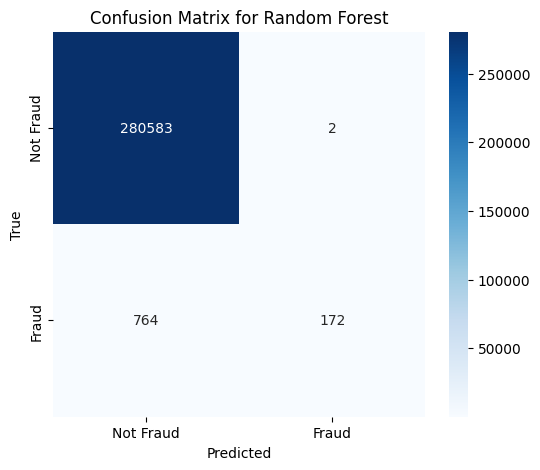

C:\Users\oscar\AppData\Local\Temp\ipykernel_6248\982896639.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


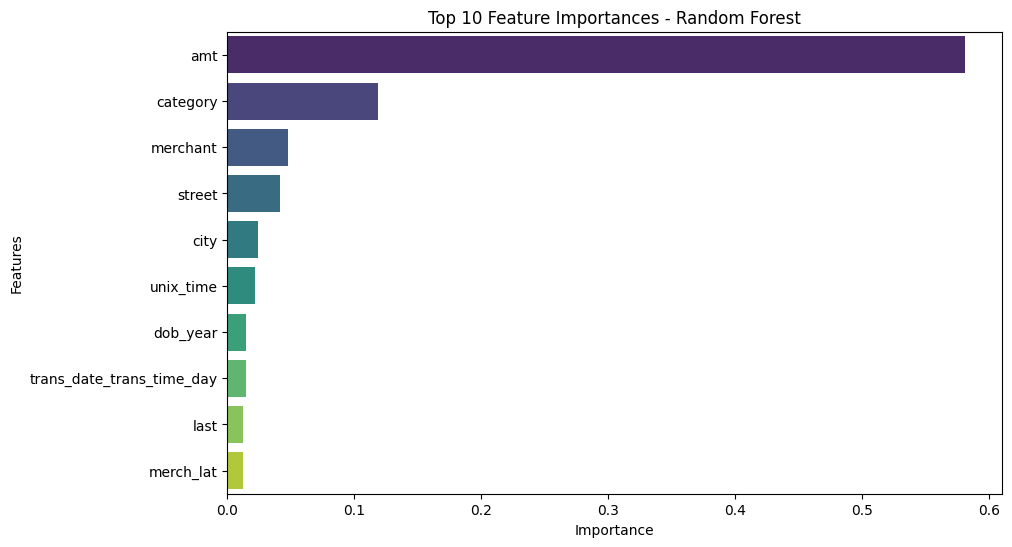

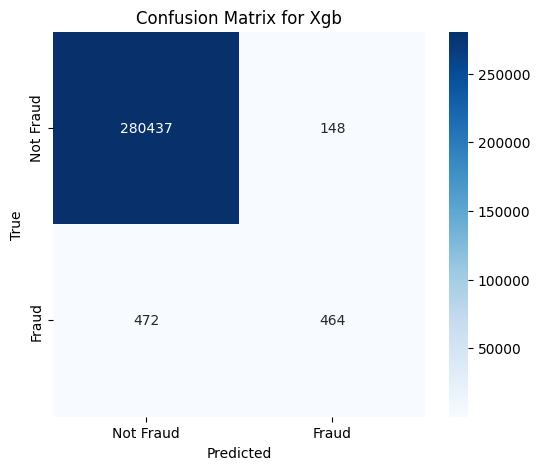

C:\Users\oscar\AppData\Local\Temp\ipykernel_6248\982896639.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


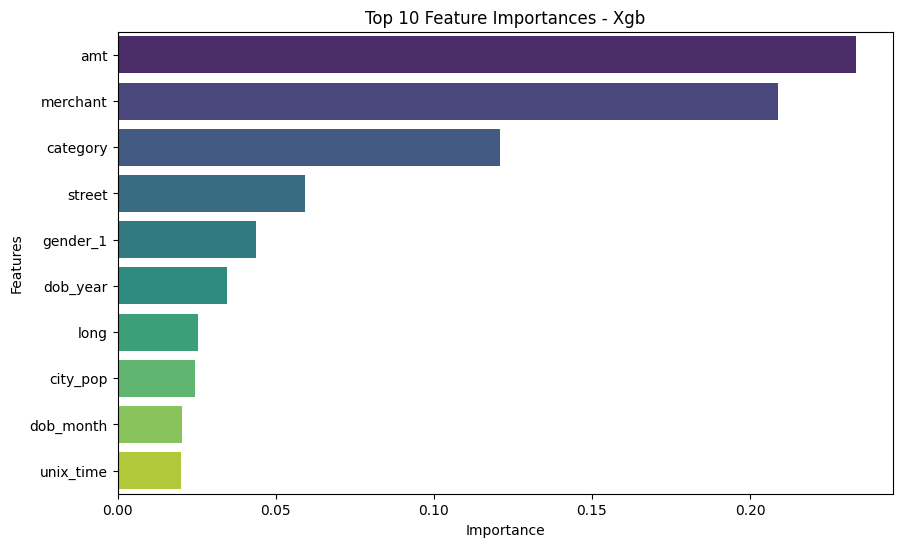

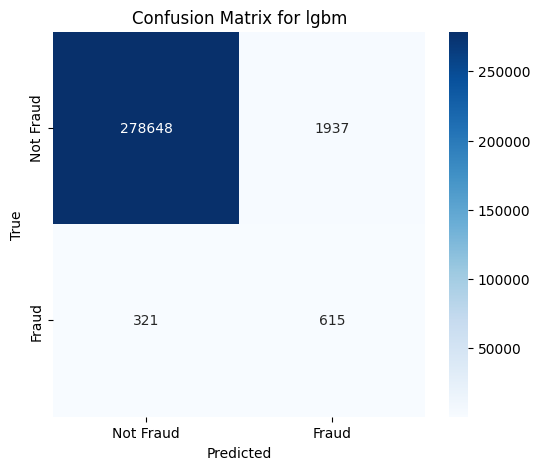

C:\Users\oscar\AppData\Local\Temp\ipykernel_6248\982896639.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


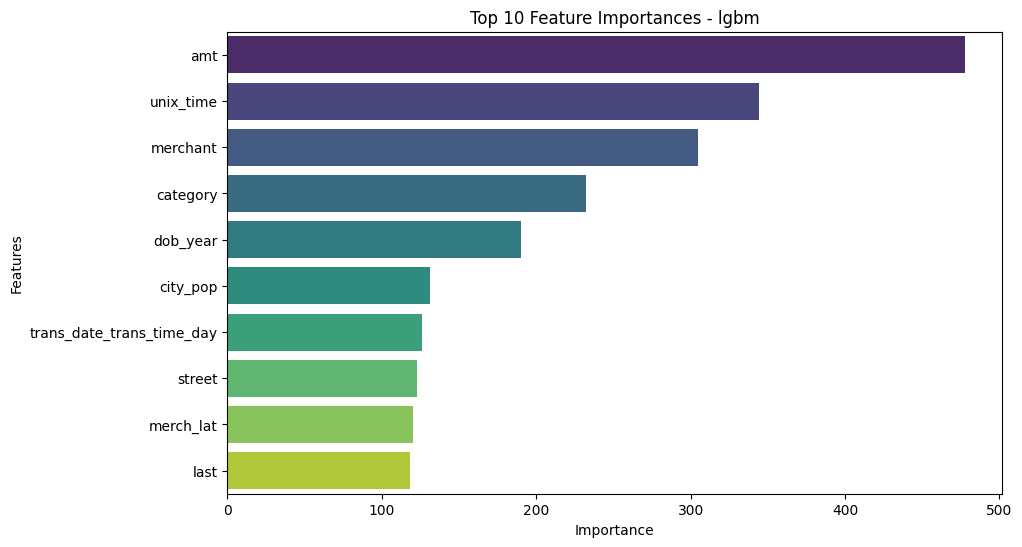

,Model Name,Accuracy_score,Precision_score,Recall,F1_score,ROC_AUC
0,Xgb,0.997798,0.758170,0.495726,0.599483,0.747600
0,lgbm,0.991979,0.240987,0.657051,0.352638,0.825074
0,Random Forest,0.997279,0.988506,0.183761,0.309910,0.591877


In [38]:
model_list = [{'Random Forest': rf} ,{'Xgb':xgb_model},{'lgbm':lgb_model}]

df_list = []

for model in model_list:

    model_name = list(model.keys())[0]

    model = list(model.values())[0]

    y_pred = model.predict( X_test.drop('is_fraud', axis= 1) )

    y_pred_proba =  model.predict( X_test.drop('is_fraud',axis=1) )

    evaluation = eveluate_model( model_name, y_test ,y_pred, y_pred_proba)

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    importances = model.feature_importances_
    features = X_test.drop('is_fraud', axis = 1).columns 

  
    df_importances = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    })

  
    df_importances = df_importances.sort_values(by='Importance', ascending=False)

 
    top_n = 10
    top_features = df_importances.head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
    plt.title(f'Top {top_n} Feature Importances - {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()

    
    df_list.append( evaluation )

pd.concat( df_list, axis = 0 ).sort_values( by = 'F1_score', ascending = False )

    
    

